In [1]:
%pylab inline
import os
from collections import namedtuple
import pyro
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)

Populating the interactive namespace from numpy and matplotlib


## Dataset

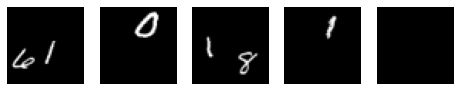

In [2]:

inpath = './air/.data'
X_np, _ = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = torch.from_numpy(X_np)
def show_images(imgs):
    figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        subplot(1, len(imgs), i + 1)
        axis('off')
        imshow(img.data.numpy(), cmap='gray')
show_images(mnist[9:14])

## Prior

In [3]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(50, 200)
        self.l2 = nn.Linear(200, 400)

    def forward(self, z_what):
        h = relu(self.l1(z_what))
        return sigmoid(self.l2(h))

decode = Decoder()

In [4]:
z_where_prior_loc = torch.tensor([3., 0., 0.])
z_where_prior_scale = torch.tensor([0.1, 1., 1.])
z_what_prior_loc = torch.zeros(50)
z_what_prior_scale = torch.ones(50)

In [5]:
def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = torch.LongTensor([1, 0, 2, 0, 1, 3])
    out = torch.cat((torch.zeros([1, 1]).expand(n, 1), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

In [6]:
def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)

In [7]:

def prior_step(n, t, prev_x, prev_z_pres):

    # Sample variable indicating whether to add this object to the output.

    # We multiply the success probability of 0.5 by the value sampled for this
    # choice in the previous step. By doing so we add objects to the output until
    # the first 0 is sampled, after which we add no further objects.
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(0.5 * prev_z_pres)
                             .to_event(1))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_prior_loc.expand(n, -1),
                                      z_where_prior_scale.expand(n, -1))
                              .mask(z_pres)
                              .to_event(1))

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_prior_loc.expand(n, -1),
                                     z_what_prior_scale.expand(n, -1))
                             .mask(z_pres)
                             .to_event(1))

    y_att = decode(z_what)
    y = object_to_image(z_where, y_att)

    # Combine the image generated at this step with the image so far.
    x = prev_x + y * z_pres.view(-1, 1, 1)

    return x, z_pres

In [8]:

def prior(n):
    x = torch.zeros(n, 50, 50)
    z_pres = torch.ones(n, 1)
    for t in range(3):
        x, z_pres = prior_step(n, t, x, z_pres)
    return x

/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specif

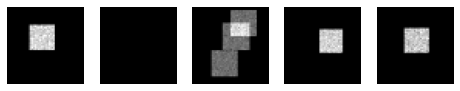

In [9]:
pyro.set_rng_seed(0)
show_images(prior(5))

## Model

In [1]:
def model(data):
    # Register network for optimization.
    pyro.module("decode", decode)
    with pyro.plate('data', data.size(0)) as indices:
        batch = data[indices]
        x = prior(batch.size(0)).view(-1, 50 * 50)
        sd = (0.3 * torch.ones(1)).expand_as(x)
        pyro.sample('obs', dist.Normal(x, sd).to_event(1),
                    obs=batch)

## Image to Object

In [11]:

def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = z_where.size(0)
    out = torch.cat((torch.ones([1, 1]).type_as(z_where).expand(n, 1), -z_where[:, 1:]), 1)
    out = out / z_where[:, 0:1]
    return out

def image_to_object(z_where, image):
    n = image.size(0)
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid(theta_inv, torch.Size((n, 1, 20, 20)))
    out = grid_sample(image.view(n, 1, 50, 50), grid)
    return out.view(n, -1)

## Object Encoder/Decoder

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(400, 200)
        self.l2 = nn.Linear(200, 100)

    def forward(self, data):
        h = relu(self.l1(data))
        a = self.l2(h)
        return a[:, 0:50], softplus(a[:, 50:])

encode = Encoder()

In [13]:
class Predict(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.l = nn.Linear(256, 7)

    def forward(self, h):
        a = self.l(h)
        z_pres_p = sigmoid(a[:, 0:1]) # Squish to [0,1]
        z_where_loc = a[:, 1:4]
        z_where_scale = softplus(a[:, 4:]) # Squish to >0
        return z_pres_p, z_where_loc, z_where_scale

predict = Predict()

## Baseline

In [14]:
bl_rnn = nn.LSTMCell(2554, 256)
bl_predict = nn.Linear(256, 1)

# Use an RNN to compute the baseline value. This network takes the
# input images and the values samples so far as input.
def baseline_step(x, prev):
    rnn_input = torch.cat((x,
                           prev.z_where.detach(),
                           prev.z_what.detach(),
                           prev.z_pres.detach()), 1)
    bl_h, bl_c = bl_rnn(rnn_input, (prev.bl_h, prev.bl_c))
    bl_value = bl_predict(bl_h) * prev.z_pres
    return bl_value, bl_h, bl_c

## Guide

In [15]:
rnn = nn.LSTMCell(2554, 256)


In [16]:
GuideState = namedtuple('GuideState', ['h', 'c', 'bl_h', 'bl_c', 'z_pres', 'z_where', 'z_what'])


In [17]:
def initial_guide_state(n):
    return GuideState(h=torch.zeros(n, 256),
                      c=torch.zeros(n, 256),
                      bl_h=torch.zeros(n, 256),
                      bl_c=torch.zeros(n, 256),
                      z_pres=torch.ones(n, 1),
                      z_where=torch.zeros(n, 3),
                      z_what=torch.zeros(n, 50))

In [18]:
def guide_step(t, data, prev):

    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)

    # Here we compute the baseline value, and pass it to sample.
    baseline_value, bl_h, bl_c = baseline_step(data, prev)
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(z_pres_p * prev.z_pres)
                             .to_event(1),
                         infer=dict(baseline=dict(baseline_value=baseline_value.squeeze(-1))))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_loc, z_where_scale)
                              .mask(z_pres)
                              .to_event(1))

    x_att = image_to_object(z_where, data)

    z_what_loc, z_what_scale = encode(x_att)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_loc, z_what_scale)
                             .mask(z_pres)
                             .to_event(1))

    return GuideState(h=h, c=c, bl_h=bl_h, bl_c=bl_c, z_pres=z_pres, z_where=z_where, z_what=z_what)


In [19]:
def guide(data):
    # Register networks for optimization.
    pyro.module('rnn', rnn),
    pyro.module('predict', predict),
    pyro.module('encode', encode),
    pyro.module('bl_rnn', bl_rnn)
    pyro.module('bl_predict', bl_predict)

    with pyro.plate('data', data.size(0), subsample_size=64) as indices:
        batch = data[indices]
        state = initial_guide_state(batch.size(0))
        steps = []
        for t in range(3):
            state = guide_step(t, batch, state)
            steps.append(state)
        return steps

## Putting it all together

In [20]:
data = mnist.view(-1, 50 * 50)


In [23]:
svi = SVI(model,
          guide,
          optim.Adam({'lr': 1e-4}),
          loss=TraceGraph_ELBO())

for i in range(500):
    loss = svi.step(data)
    print('i={}, elbo={:.2f}'.format(i, loss / data.size(0)))

i=0, elbo=3005.62
i=1, elbo=2933.69
i=2, elbo=3019.81
i=3, elbo=2960.32
i=4, elbo=1509.96
i=5, elbo=3102.87
i=6, elbo=2245.66
i=7, elbo=1060.41
i=8, elbo=2827.52
i=9, elbo=1571.43
i=10, elbo=2627.56
i=11, elbo=2498.86
i=12, elbo=2572.19
i=13, elbo=532.53
i=14, elbo=1585.15
i=15, elbo=1314.62
i=16, elbo=1815.75
i=17, elbo=1818.09
i=18, elbo=1769.63
i=19, elbo=1650.59
i=20, elbo=3098.61
i=21, elbo=1807.97
i=22, elbo=1073.84
i=23, elbo=883.28
i=24, elbo=1543.75
i=25, elbo=1301.94
i=26, elbo=1971.35
i=27, elbo=1470.16
i=28, elbo=1649.76
i=29, elbo=2012.27
i=30, elbo=1257.56
i=31, elbo=1658.94
i=32, elbo=461.78
i=33, elbo=1086.29
i=34, elbo=2194.71
i=35, elbo=2691.48
i=36, elbo=1705.28
i=37, elbo=1776.98
i=38, elbo=1256.41
i=39, elbo=1271.07
i=40, elbo=774.90
i=41, elbo=1059.32
i=42, elbo=1673.45
i=43, elbo=1342.31
i=44, elbo=836.40
i=45, elbo=2315.56
i=46, elbo=2578.26
i=47, elbo=794.44
i=48, elbo=1260.01
i=49, elbo=2023.54
i=50, elbo=963.89
i=51, elbo=2093.27
i=52, elbo=1822.05
i=53, elbo

i=430, elbo=-367.64
i=431, elbo=-161.44
i=432, elbo=-256.58
i=433, elbo=-238.90
i=434, elbo=-286.53
i=435, elbo=-288.72
i=436, elbo=-226.26
i=437, elbo=-316.83
i=438, elbo=-285.12
i=439, elbo=-133.33
i=440, elbo=-310.69
i=441, elbo=-300.47
i=442, elbo=-309.10
i=443, elbo=-197.11
i=444, elbo=-326.87
i=445, elbo=-254.82
i=446, elbo=-157.24
i=447, elbo=-232.53
i=448, elbo=-259.01
i=449, elbo=-253.54
i=450, elbo=-281.94
i=451, elbo=-246.69
i=452, elbo=-233.21
i=453, elbo=-231.02
i=454, elbo=-223.39
i=455, elbo=-229.06
i=456, elbo=-292.59
i=457, elbo=-220.98
i=458, elbo=-269.75
i=459, elbo=-318.00
i=460, elbo=-303.00
i=461, elbo=-279.65
i=462, elbo=-296.96
i=463, elbo=-304.63
i=464, elbo=-149.78
i=465, elbo=-306.35
i=466, elbo=-331.80
i=467, elbo=-285.57
i=468, elbo=-255.75
i=469, elbo=-346.62
i=470, elbo=-324.36
i=471, elbo=-256.21
i=472, elbo=-326.81
i=473, elbo=-281.89
i=474, elbo=-259.62
i=475, elbo=-308.95
i=476, elbo=-343.13
i=477, elbo=-288.52
i=478, elbo=-310.98
i=479, elbo=-303.05
